In [3]:
# %pip install snowflake-connector-python
# %pip install python-dotenv
# %pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import snowflake.connector as sf
from dotenv import load_dotenv
import os

In [3]:
#import python package
import json
import sys
# import cachetools

#import Snowflake modules
from snowflake.snowpark import Session
# import snowflake.snowpark.function as F
import snowflake.snowpark.types as T
# Do insert with Credentials in .env instead
load_dotenv()

# Connect to Snowflake
USER = os.getenv("SNOWFLAKE_USER")
PASSWORD = os.getenv("SNOWFLAKE_PASSWORD")
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")
WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE")
DATABASE = os.getenv("SNOWFLAKE_DATABASE")
SCHEMA = os.getenv("SNOWFLAKE_SCHEMA")
ROLE = os.getenv("SNOWFLAKE_ROLE")

In [4]:
# ctx = sf.connect(
#     user=USER,
#     password=PASSWORD,
#     account=ACCOUNT,
#     warehouse=WAREHOUSE,
#     database=DATABASE,
#     schema=SCHEMA,
#     role=ROLE,
#     session_parameters={
#         'QUERY_TAG': 'Panha Project Jupiter Notebook',
#     }
# )

# specify connection parameters
connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": ROLE,
    "warehouse": WAREHOUSE,
    "database": DATABASE,
    "schema": SCHEMA,
}

# create Snowpark session
session = Session.builder.configs(connection_parameters).create()

c:\Users\panha.vuthy\AppData\Local\Programs\Python\Python311\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\panha.vuthy\AppData\Local\snowflake\config.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


In [7]:
# Select from Fact table: Date, PRODUCT_SKU, GROSS_SALES, NUMBER_OF_ORDERS, NUMBER_OF_CUSTOMERS, NUMBER_OF_UNITS_SOLD, CUSTOMER_SEGMENT, AVG_DISCOUNT_RATE, COST_OF_GOODS_SOLD

In [8]:
# def exec_query(query):
#     cs = ctx.cursor()
#     try:
#         cs.execute(query)
#         return cs.fetchall()
#     finally:
#         cs.close()

In [5]:
# Treat outliers in the 'NUM_ORDERS' column
def treat_outliers(df, column, outlier_percentages):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # if any of the numerical columns have outliers that under 5%, we can keep them, otherwise we treat theme with mean imputation
    if outlier_percentages[column] < 5:
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    else:
        df[column] = np.where(df[column] < lower_bound, df[column].mean(), df[column])
        df[column] = np.where(df[column] > upper_bound, df[column].mean(), df[column])
    return df

In [6]:
product_sku = 'B33_S3'

# 1. Data Collection

This part we will forcus on only Product SKU = ```B33_S3```

In [13]:
raw_data = session.sql(f"""
SELECT 
    FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU_RETAIL_PRICE AS "RETAIL_RPICE",
    REL_CUS_SEGMENTATION_RFM.CLUSTER AS "CUSTOMER_SEGMENT",
    COUNT(DISTINCT(FACT_ORDER_LINE_ITEM_BASE.ORDER_CODE)) AS "NUM_ORDERS",
    SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNITS_SOLD",
    AVG(FACT_ORDER_LINE_ITEM_BASE.DISCOUNT_RATE) AS "AVG_DISCOUNT_RATE",
    SUM(FACT_ORDER_LINE_ITEM_BASE.SUPPLY_UNIT_COST) AS "COGS",
FROM 
    LU_PRD_PRODUCT_SKU
JOIN 
    LU_PRD_PRODUCT
ON 
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
JOIN 
    FACT_ORDER_LINE_ITEM_BASE 
ON 
    FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
JOIN 
    LU_CUS_CUSTOMER 
ON
    LU_CUS_CUSTOMER.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
JOIN 
    REL_CUS_SEGMENTATION_RFM
ON
    REL_CUS_SEGMENTATION_RFM.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
WHERE
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN  ('{product_sku}')
    AND (YEAR(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) BETWEEN 2021 AND 2023)
GROUP BY
    DATE, RETAIL_RPICE, CUSTOMER_SEGMENT
ORDER BY
    DATE ASC
""").collect()

In [14]:
df_raw_data = pd.DataFrame(raw_data)

In [15]:
df_raw_data

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
0,2021-01-01,1497.736864,2,1,30.00,0.08000000,917.30
1,2021-01-01,1497.736864,0,6,150.00,0.04000000,4058.74
2,2021-01-02,1497.736864,0,1,35.00,0.01000000,758.38
3,2021-01-02,1497.736864,1,3,105.00,0.05000000,749.34
4,2021-01-03,1497.736864,1,1,18.00,0E-8,387.60
...,...,...,...,...,...,...,...
1570,2023-08-01,1497.736864,1,2,57.00,0.04000000,945.70
1571,2023-08-01,1497.736864,0,2,69.00,0.05000000,716.47
1572,2023-08-02,1497.736864,2,1,32.00,0.07000000,537.84
1573,2023-08-02,1497.736864,0,1,3.00,0.05000000,761.72


In [12]:
# Convert raw_data to DataFrame
# columns = ["DATE", "RETAIL_RPICE", "CUSTOMER_SEGMENT", "NUM_ORDERS", "UNITS_SOLD", "AVG_DISCOUNT_RATE", "COGS"]
# df_raw_data = pd.DataFrame(raw_data, columns=columns)

1. Understand Structure of Dataset

In [16]:
df_raw_data.head()

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
0,2021-01-01,1497.736864,2,1,30.00,0.08000000,917.30
1,2021-01-01,1497.736864,0,6,150.00,0.04000000,4058.74
2,2021-01-02,1497.736864,0,1,35.00,0.01000000,758.38
3,2021-01-02,1497.736864,1,3,105.00,0.05000000,749.34
4,2021-01-03,1497.736864,1,1,18.00,0E-8,387.60


# 2. Data Exploration

In [17]:
print(f"Number of rows: {df_raw_data.shape[0]}")
print(f"Number of columns: {df_raw_data.shape[1]}")

Number of rows: 1575
Number of columns: 7


In [18]:
print("Checking Column Data Types")
df_raw_data.info()

Checking Column Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               1575 non-null   object 
 1   RETAIL_RPICE       1575 non-null   float64
 2   CUSTOMER_SEGMENT   1575 non-null   int64  
 3   NUM_ORDERS         1575 non-null   int64  
 4   UNITS_SOLD         1575 non-null   object 
 5   AVG_DISCOUNT_RATE  1575 non-null   object 
 6   COGS               1575 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 86.3+ KB


In [19]:
# Convert UUNIT_SOLD to int, AVG_DISCOUNT_RATE to float, and COGS to float
df_raw_data['UNITS_SOLD'] = df_raw_data['UNITS_SOLD'].astype(int)
df_raw_data['AVG_DISCOUNT_RATE'] = df_raw_data['AVG_DISCOUNT_RATE'].astype(float)
df_raw_data['COGS'] = df_raw_data['COGS'].astype(float)

#Convert Customer Segment to Category
df_raw_data['CUSTOMER_SEGMENT'] = df_raw_data['CUSTOMER_SEGMENT'].astype('category')

2. Summarize Data

In [20]:
print("Descriptive Statistics on numerical columns")
df_raw_data.describe(include=[np.number])

Descriptive Statistics on numerical columns


,RETAIL_RPICE,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS
count,1.575000e+03,1575.000000,1575.000000,1575.000000,1575.000000
mean,1.497737e+03,1.506667,38.958730,0.050221,781.941562
std,2.274459e-13,0.779209,27.392534,0.028555,534.425070
min,1.497737e+03,1.000000,1.000000,0.000000,2.220000
25%,1.497737e+03,1.000000,19.000000,0.030000,392.975000
50%,1.497737e+03,1.000000,35.000000,0.050000,735.000000
75%,1.497737e+03,2.000000,50.000000,0.070000,984.655000
max,1.497737e+03,6.000000,175.000000,0.100000,4058.740000


In [21]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   DATE               1575 non-null   object  
 1   RETAIL_RPICE       1575 non-null   float64 
 2   CUSTOMER_SEGMENT   1575 non-null   category
 3   NUM_ORDERS         1575 non-null   int64   
 4   UNITS_SOLD         1575 non-null   int64   
 5   AVG_DISCOUNT_RATE  1575 non-null   float64 
 6   COGS               1575 non-null   float64 
dtypes: category(1), float64(3), int64(2), object(1)
memory usage: 75.6+ KB


In [22]:
print("Descriptive Statistics on categorical columns")
df_raw_data.describe(include=[pd.Categorical, 'category'])

Descriptive Statistics on categorical columns


,DATE,CUSTOMER_SEGMENT
count,1575,1575
unique,875,3
top,2022-08-15,0
freq,3,618


3. Handle Missing Data

In [23]:
df_raw_data.isnull().sum()

DATE                 0
RETAIL_RPICE         0
CUSTOMER_SEGMENT     0
NUM_ORDERS           0
UNITS_SOLD           0
AVG_DISCOUNT_RATE    0
COGS                 0
dtype: int64

In [24]:
# incase there is missing data, drop the rows with missing data
df_raw_data.dropna(inplace=True)

4. Outliers Detection

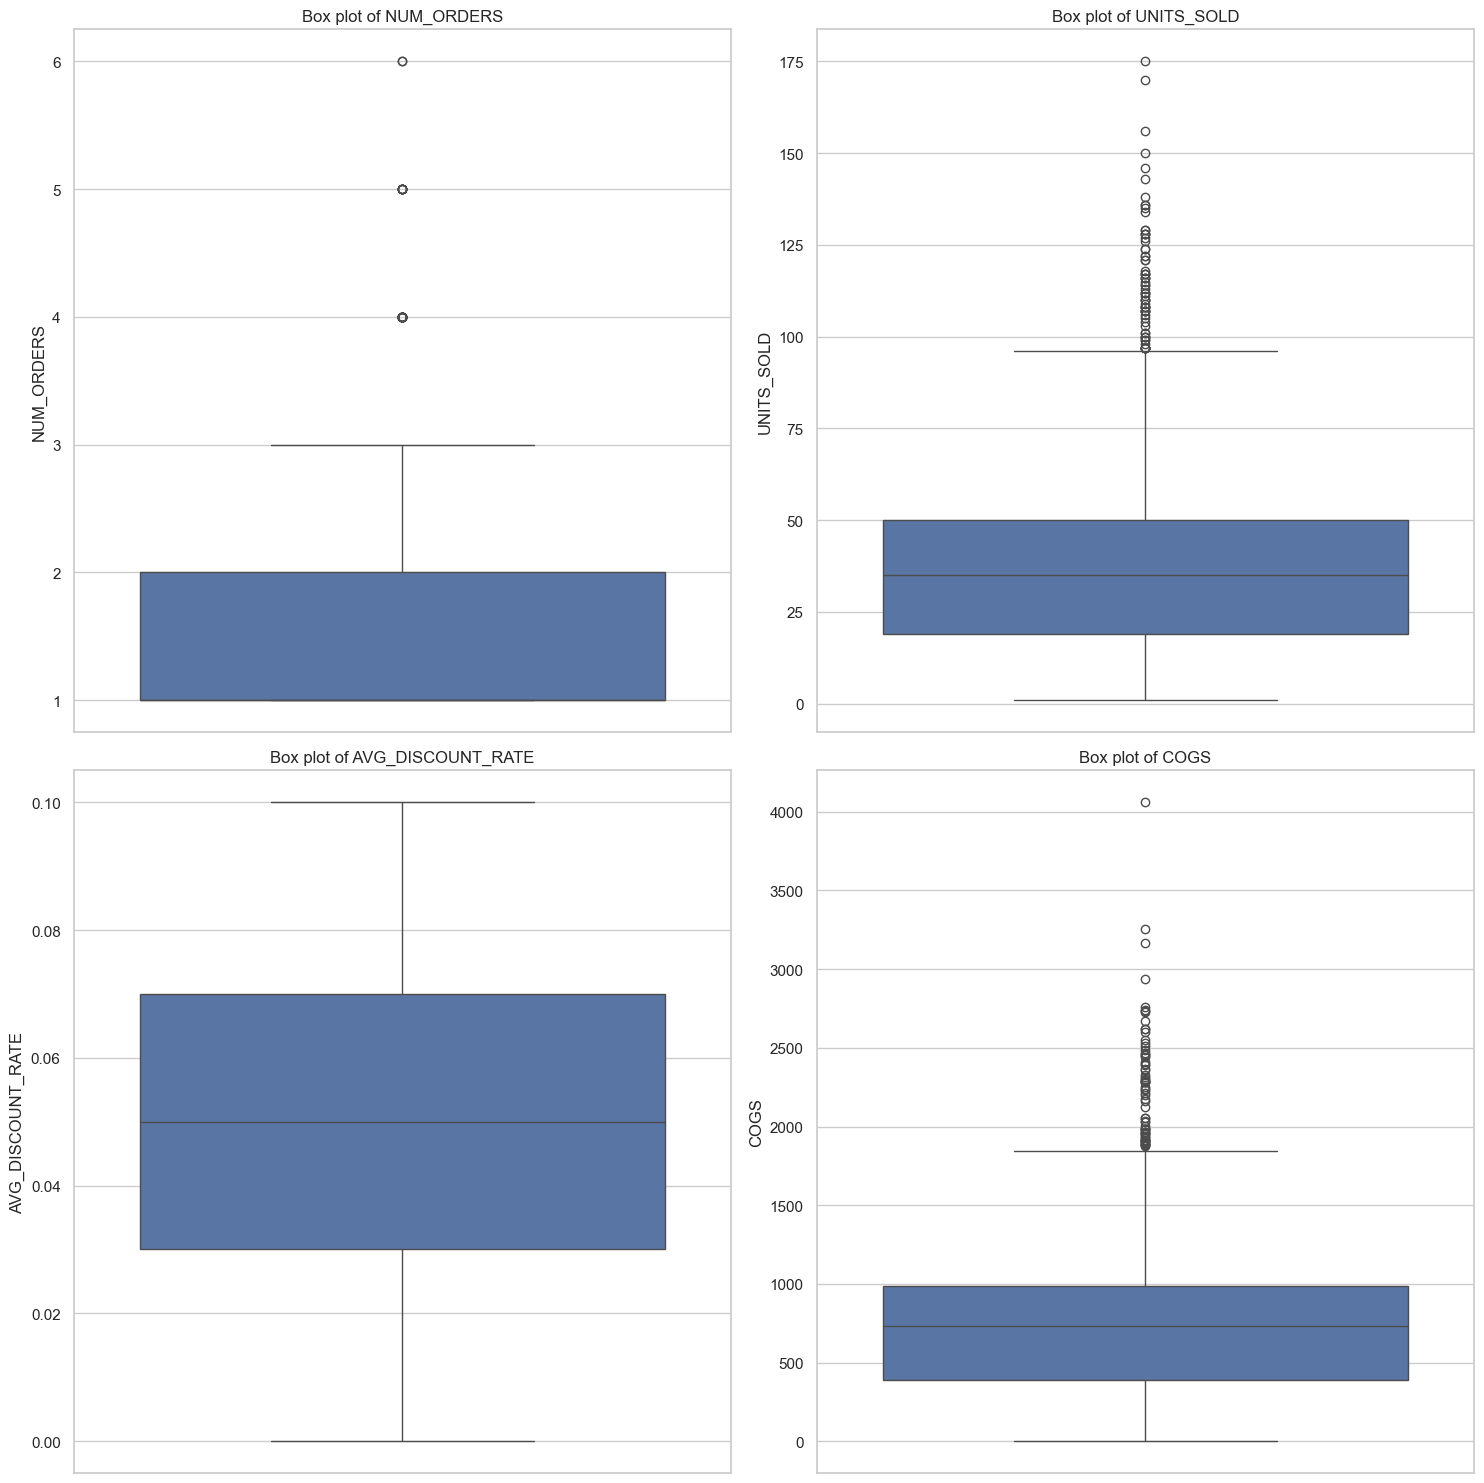

In [25]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style of the visualization
sns.set_theme(style="whitegrid")

# Create a figure and axis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# List of numerical columns to plot
numerical_columns = ['NUM_ORDERS', 'UNITS_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']

# Plot each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(y=df_raw_data[column], ax=ax)
    ax.set_title(f'Box plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [26]:
# Calculate the percentage of outliers for each numerical column
outlier_percentages = {}

for column in numerical_columns:
    Q1 = df_raw_data[column].quantile(0.25)
    Q3 = df_raw_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_raw_data[(df_raw_data[column] < lower_bound) | (df_raw_data[column] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_raw_data)) * 100
    outlier_percentages[column] = outlier_percentage


print("Percentage of outliers in each numerical column")
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

Percentage of outliers in each numerical column
NUM_ORDERS: 2.48%
UNITS_SOLD: 4.44%
AVG_DISCOUNT_RATE: 0.00%
COGS: 4.44%


In [27]:
# Treat outliers in the 'NUM_ORDERS' column
def treat_outliers(df, column, outlier_percentages):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # if any of the numerical columns have outliers that under 5%, we can keep them, otherwise we treat theme with mean imputation
    if outlier_percentages[column] > 5:
        df[column] = np.where(df[column] < lower_bound, df[column].mean(), df[column])
        df[column] = np.where(df[column] > upper_bound, df[column].mean(), df[column])
    return df

In [28]:
df_raw_data = treat_outliers(df_raw_data, 'NUM_ORDERS', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'UNITS_SOLD', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'AVG_DISCOUNT_RATE', outlier_percentages)
df_raw_data = treat_outliers(df_raw_data, 'COGS', outlier_percentages)

In [29]:
print(f'% of outliers in each numerical column')
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

% of outliers in each numerical column
NUM_ORDERS: 2.48%
UNITS_SOLD: 4.44%
AVG_DISCOUNT_RATE: 0.00%
COGS: 4.44%


In [30]:
# check duplicate rows
duplicate_rows = df_raw_data[df_raw_data.duplicated()]
duplicate_rows.count()

DATE                 0
RETAIL_RPICE         0
CUSTOMER_SEGMENT     0
NUM_ORDERS           0
UNITS_SOLD           0
AVG_DISCOUNT_RATE    0
COGS                 0
dtype: int64

5. Understand the Distribution

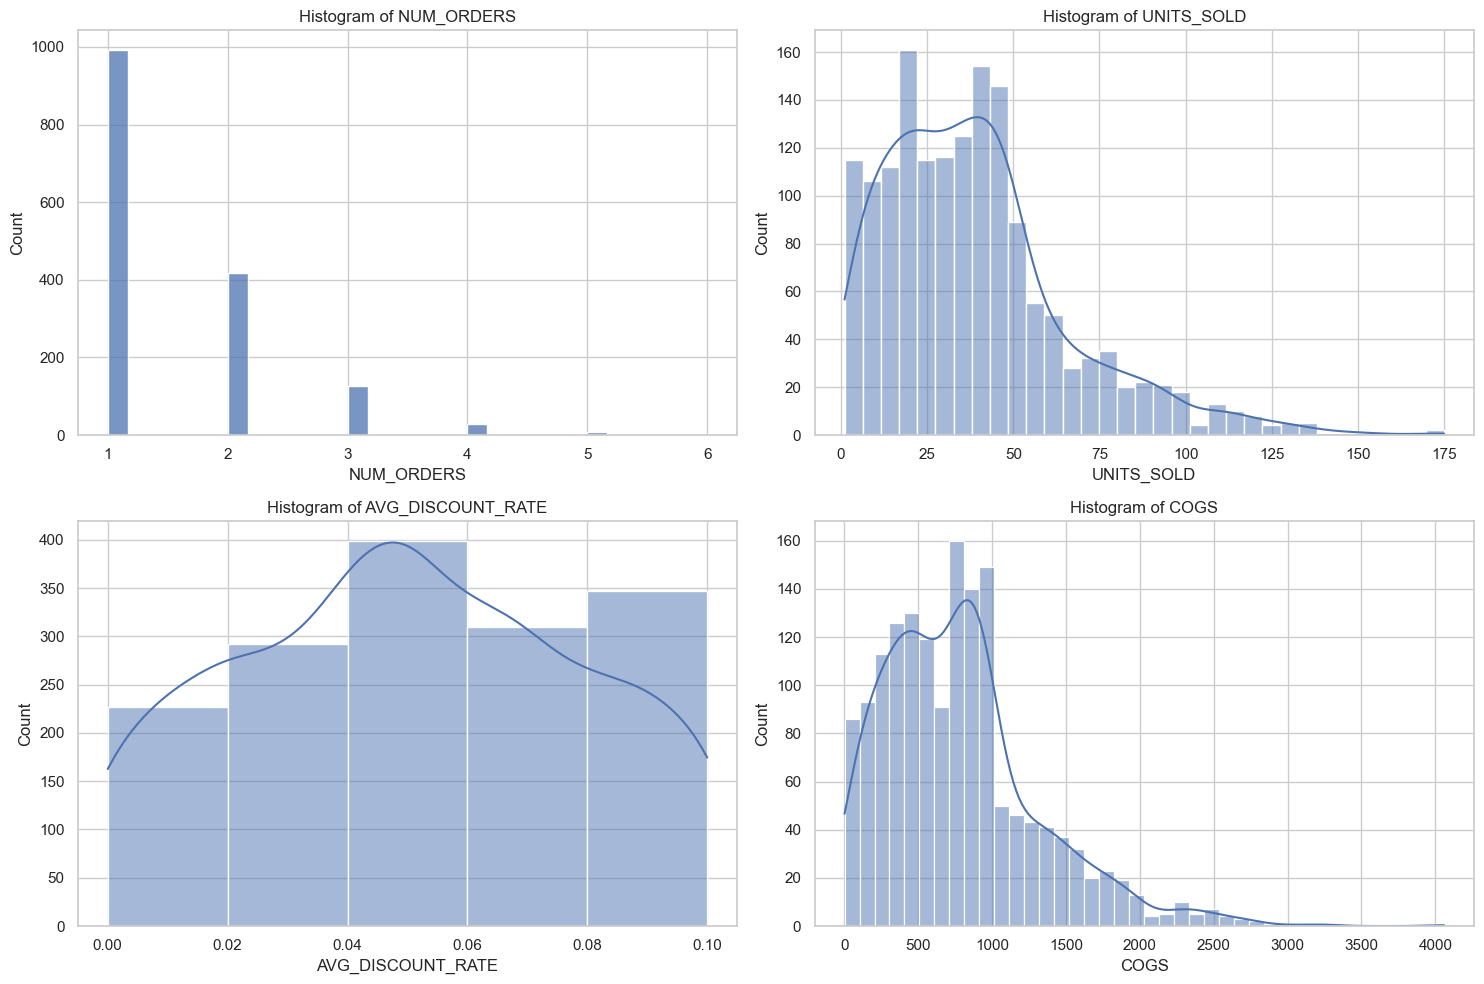

In [31]:
# Plot histograms for numeric features to understand their distribution
columns_for_hist = ['NUM_ORDERS','UNITS_SOLD', 'AVG_DISCOUNT_RATE', 'COGS']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot each numerical column
for ax, column in zip(axes.flatten(), columns_for_hist):
    if column == 'AVG_DISCOUNT_RATE':
        sns.histplot(df_raw_data[column], kde=True, bins=5, ax=ax)  # 4 or 5 bins
    elif column == 'NUM_ORDERS':
        sns.histplot(df_raw_data[column], ax=ax)
    else:
        sns.histplot(df_raw_data[column], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [32]:
# Calculate skewness and kurtosis for each numerical column
skewness = df_raw_data[numerical_columns].skew()
kurtosis = df_raw_data[numerical_columns].kurt()

print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 NUM_ORDERS           1.764771
UNITS_SOLD           1.218976
AVG_DISCOUNT_RATE    0.009150
COGS                 1.189456
dtype: float64

Kurtosis:
 NUM_ORDERS           3.644543
UNITS_SOLD           1.902015
AVG_DISCOUNT_RATE   -0.965090
COGS                 2.219711
dtype: float64


# 3. Data Preprocessing

In [33]:
# Convert DATE column to datetime
df_raw_data['DATE'] = pd.to_datetime(df_raw_data['DATE'])

df_raw_data['DATE_ORDINAL'] = df_raw_data['DATE'].apply(lambda x: x.toordinal())

df_raw_data.head()

,DATE,RETAIL_RPICE,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,2021-01-01,1497.736864,2,1,30,0.08,917.30,737791
1,2021-01-01,1497.736864,0,6,150,0.04,4058.74,737791
2,2021-01-02,1497.736864,0,1,35,0.01,758.38,737792
3,2021-01-02,1497.736864,1,3,105,0.05,749.34,737792
4,2021-01-03,1497.736864,1,1,18,0.00,387.60,737793


In [34]:
retail_price = df_raw_data['RETAIL_RPICE'][0]

6. Analyse relationship between variable

In [35]:
# Select all columns except 'RETAIL_RPICE'
df_selected = df_raw_data.drop(columns=['RETAIL_RPICE', 'DATE'])

# Display the first few rows to verify the changes
df_selected.head()

,CUSTOMER_SEGMENT,NUM_ORDERS,UNITS_SOLD,AVG_DISCOUNT_RATE,COGS,DATE_ORDINAL
0,2,1,30,0.08,917.30,737791
1,0,6,150,0.04,4058.74,737791
2,0,1,35,0.01,758.38,737792
3,1,3,105,0.05,749.34,737792
4,1,1,18,0.00,387.60,737793


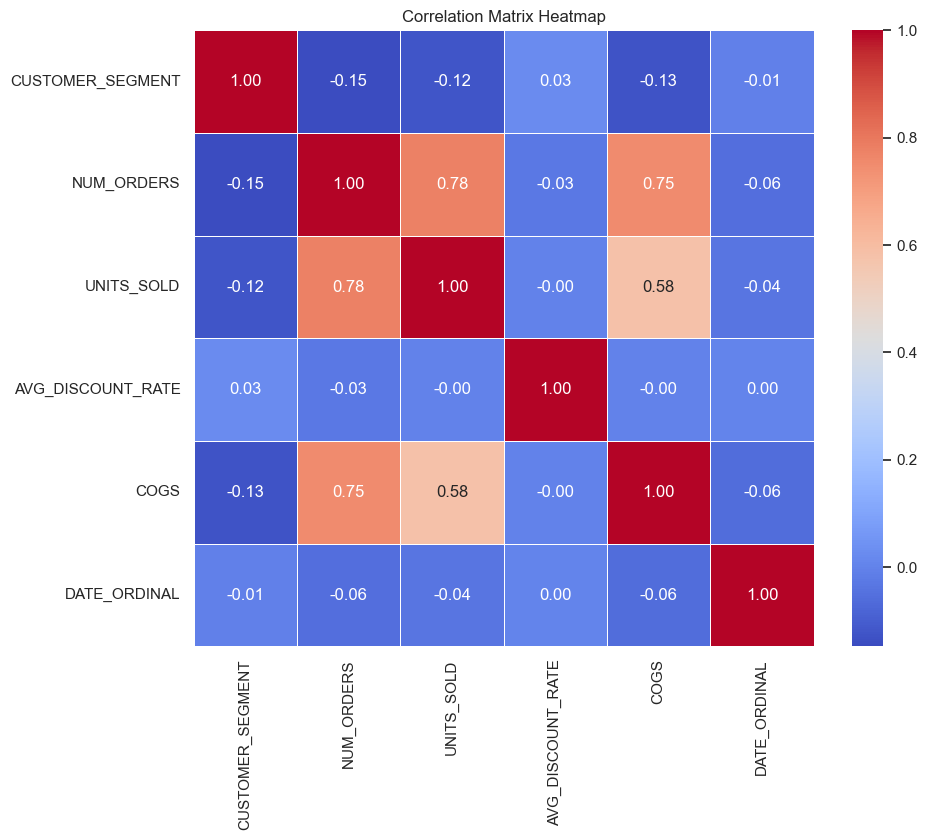

In [36]:
# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

7. Analyze Categorical Variables

Frequency Distribution of CUSTOMER_SEGMENT:
 CUSTOMER_SEGMENT
0    618
1    533
2    424
Name: count, dtype: int64


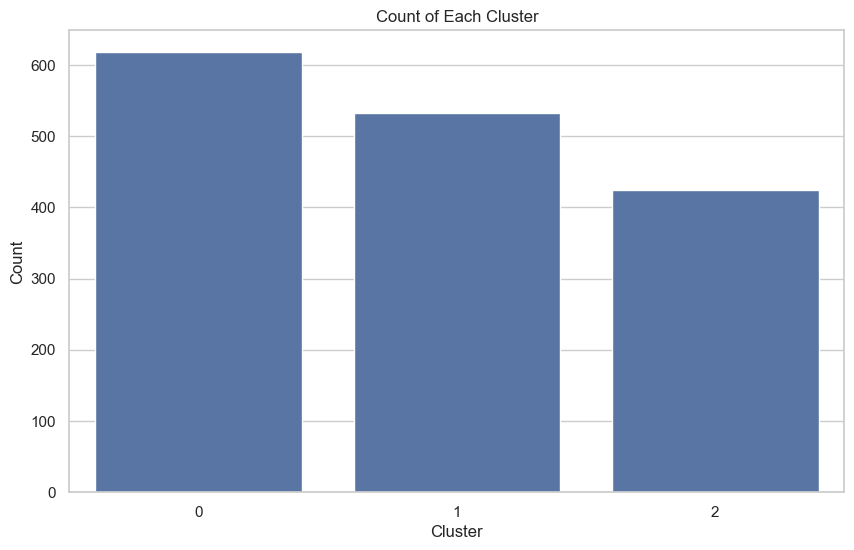

Cross-tabulation between CLUSTER and NUM_ORDERS:
 NUM_ORDERS          1    2   3   4  5  6
CUSTOMER_SEGMENT                        
0                 347  185  63  16  5  2
1                 340  136  46   8  3  0
2                 306   96  17   5  0  0


In [37]:
# Frequency Distribution
cluster_counts = df_raw_data['CUSTOMER_SEGMENT'].value_counts()
print("Frequency Distribution of CUSTOMER_SEGMENT:\n", cluster_counts)

# Bar Plots
plt.figure(figsize=(10, 6))
sns.countplot(x='CUSTOMER_SEGMENT', data=df_raw_data)
plt.title('Count of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Cross-tabulation
cross_tab = pd.crosstab(df_raw_data['CUSTOMER_SEGMENT'], df_raw_data['NUM_ORDERS'])
print("Cross-tabulation between CLUSTER and NUM_ORDERS:\n", cross_tab)

In [38]:
# Select the required columns for independent variables and target variable
df_model = df_raw_data[['DATE_ORDINAL', 'UNITS_SOLD', 'CUSTOMER_SEGMENT', 'AVG_DISCOUNT_RATE']]

# Display the first few rows to verify the changes
df_model.head()

,DATE_ORDINAL,UNITS_SOLD,CUSTOMER_SEGMENT,AVG_DISCOUNT_RATE
0,737791,30,2,0.08
1,737791,150,0,0.04
2,737792,35,0,0.01
3,737792,105,1,0.05
4,737793,18,1,0.00


In [39]:
# %pip install scikit-learn

In [40]:
df_model['CUSTOMER_SEGMENT'] = df_model['CUSTOMER_SEGMENT'].astype('int')

C:\Users\panha.vuthy\AppData\Local\Temp\ipykernel_23084\2429274606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['CUSTOMER_SEGMENT'] = df_model['CUSTOMER_SEGMENT'].astype('int')


In [41]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training and 20% testing
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)

# Display the size of the training and testing sets
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")

Training set size: 1260
Testing set size: 315


In [39]:
# %pip install xgboost

# 4. Model chosen and Modeling

## Create a Stage

In [40]:
# %pip install snowflake-snowpark-python

In [42]:
# Function to create the table if it doesn't exist
def create_table_if_not_exists(table_name):
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        DATE_ORDINAL INT,
        UNITS_SOLD INT,
        CUSTOMER_SEGMENT INT,
        AVG_DISCOUNT_RATE FLOAT,
        PRODUCT_SKU STRING
    );
    """
    session.sql(create_table_query).collect()  # Execute the query

In [43]:
# Function to insert the pandas dataframe into Snowflake table using Snowpark
def insert_pandas_dataframe_to_snowflake(session, pandas_df, table_name, schema):
    # Convert pandas DataFrame to Snowpark DataFrame
    snowpark_df = session.create_dataframe(pandas_df, schema=schema)

    # Write the Snowpark DataFrame into Snowflake table
    session.sql(f"DELETE FROM {table_name} WHERE PRODUCT_SKU = '{product_sku}'").collect()
    snowpark_df.write.mode("append").save_as_table(f"{table_name}")
    return snowpark_df

In [44]:
df_model['PRODUCT_SKU'] = product_sku

C:\Users\panha.vuthy\AppData\Local\Temp\ipykernel_23084\2422108455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['PRODUCT_SKU'] = product_sku


In [46]:
df_model

,DATE_ORDINAL,UNITS_SOLD,CUSTOMER_SEGMENT,AVG_DISCOUNT_RATE,PRODUCT_SKU
0,737791,150,0,0.04,B33_S3
1,737791,30,2,0.08,B33_S3
2,737792,35,0,0.01,B33_S3
3,737792,105,1,0.05,B33_S3
4,737793,18,1,0.00,B33_S3
...,...,...,...,...,...
1570,738733,57,1,0.04,B33_S3
1571,738733,69,0,0.05,B33_S3
1572,738734,3,0,0.05,B33_S3
1573,738734,32,2,0.07,B33_S3


In [45]:
from snowflake.snowpark.types import StructType, StructField, IntegerType, FloatType, StringType

training_table = "FACT_DYNAMIC_PRICING_CLEANED"
# schema structure for pandas DataFrame convert to Snowpark DataFrame
schema = StructType([
        StructField("DATE_ORDINAL", IntegerType()),
        StructField("UNITS_SOLD", IntegerType()),
        StructField("CUSTOMER_SEGMENT", IntegerType()),
        StructField("AVG_DISCOUNT_RATE", FloatType()),
        StructField("PRODUCT_SKU", StringType())
    ])

create_table_if_not_exists(training_table)
snowpark_df = insert_pandas_dataframe_to_snowflake(session, df_model, training_table, schema)
# Convert pandas DataFrame to Snowpark DataFrame

In [46]:
snowpark_df.show()

--------------------------------------------------------------------------------------------
|"DATE_ORDINAL"  |"UNITS_SOLD"  |"CUSTOMER_SEGMENT"  |"AVG_DISCOUNT_RATE"  |"PRODUCT_SKU"  |
--------------------------------------------------------------------------------------------
|737791          |30            |2                   |0.08                 |B33_S3         |
|737791          |150           |0                   |0.04                 |B33_S3         |
|737792          |35            |0                   |0.01                 |B33_S3         |
|737792          |105           |1                   |0.05                 |B33_S3         |
|737793          |18            |1                   |0.0                  |B33_S3         |
|737793          |7             |2                   |0.05                 |B33_S3         |
|737794          |19            |1                   |0.05                 |B33_S3         |
|737794          |17            |0                   |0.0             

In [49]:
# session.sql("DROP TABLE IF EXISTS FACT_DYNAMIC_PRICING_CLEANED").collect()

In [47]:
# Create a Stage
stage_name = "DYNAMIC_PRICING_MODEL_STAGE"
session.sql(f"CREATE STAGE IF NOT EXISTS {stage_name}").collect()

[Row(status='DYNAMIC_PRICING_MODEL_STAGE already exists, statement succeeded.')]

**Step 1. create a function for training a Model**

In [49]:
#from sklearn.model_selection import train_test_split

def train_xgb_model(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
    stage_name: str
) ->T.Variant:
    # Import the package
    from sklearn.model_selection import GridSearchCV
    from xgboost import XGBRegressor

    # Get training data 
    df_cleaned = session.table(training_table).to_pandas()

    train_set, test_set = train_test_split(df_cleaned, test_size=0.2, random_state=42)
    
    X_train = train_set[feature_cols]
    y_train = train_set[target_col]
    X_test = test_set[feature_cols]
    y_test = test_set[target_col]

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.2, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    # Initialize the XGBRegressor
    xgb = XGBRegressor()
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_xgb = XGBRegressor(**best_params)
    best_xgb.fit(X_train, y_train)
    y_pred = best_xgb.predict(X_test)

    mse = np.mean((y_pred - y_test) ** 2)

    print("Mean Squared Error: ", mse)
    # Save model
    dump(best_xgb, "/tmp/"+ model_name)
    session.file.put(
        "/tmp/"+ model_name,
        f"@{stage_name}/",
        auto_compress=False,
        overwrite=True
    )
    
    # combine mse and best_params into a dictionary
    result = {"mse": mse, "best_params": best_params}
    return result
    

**Step 2: Register the Function on Snowflake**

In [50]:
# train_xgb_snowflake become a stored procedure in Snowflake that can be called
train_xgb_snowflake = session.sproc.register(
    func=train_xgb_model,
    name="sproc_train_xgb_model", #spoc = stored procedure or function in snowflake
    is_permanent=True,
    replace=True,
    stage_location=stage_name,
    packages=["snowflake-snowpark-python", "scikit-learn", "xgboost", "joblib"],
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function train_xgb_model at 0x00000127DBC6C0E0>. Proceeding without creating optional arguments
The version of package 'scikit-learn' in the local environment is 1.5.2, which does not fit the criteria for the requirement 'scikit-learn'. Your UDF might not work when the package version is different between the server and your local environment.


## Model Training

Call the Training Stored Procedure

In [51]:
training_table = "FACT_DYNAMIC_PRICING_CLEANED"
model_file_name = "B33_S3_xgb_model.sav"
feature_cols = [
    'DATE_ORDINAL',
    'UNITS_SOLD',
    'CUSTOMER_SEGMENT'
]
target_col = 'AVG_DISCOUNT_RATE'

# Call the training store procedure by feeding the required parameters
result = train_xgb_snowflake(
    session,
    training_table,
    feature_cols, 
    target_col, 
    model_file_name,
    stage_name # where model file will be stored
)
result

'{\n  "best_params": {\n    "colsample_bytree": 8.000000000000000e-01,\n    "learning_rate": 2.000000000000000e-01,\n    "max_depth": 5,\n    "n_estimators": 100,\n    "subsample": 1.000000000000000e+00\n  },\n  "mse": 8.988935321682771e-04\n}'

In [67]:
result

'{\n  "best_params": {\n    "colsample_bytree": 8.000000000000000e-01,\n    "learning_rate": 2.000000000000000e-01,\n    "max_depth": 5,\n    "n_estimators": 100,\n    "subsample": 1.000000000000000e+00\n  },\n  "mse": 8.988935321682771e-04\n}'

**View the Saved Model**

In [52]:
pd.DataFrame(session.sql(f"LIST @{stage_name}").collect())

,name,size,md5,last_modified
0,dynamic_pricing_model_stage/B33_S3_xgb_model.sav,223952,116b7c056bf6e981ce2e02b29667b721,"Wed, 9 Oct 2024 03:07:45 GMT"
1,dynamic_pricing_model_stage/udf_avg_discount_r...,6304,39ba2fd3cbf388d108cdc6356e1a6406,"Tue, 8 Oct 2024 08:14:20 GMT"
2,dynamic_pricing_model_stage/udf_avg_discount_r...,5856,0d69a03fa38ac263a83d4fdf6d3cab10,"Tue, 8 Oct 2024 08:05:07 GMT"
3,dynamic_pricing_model_stage/udf_avg_discount_r...,5856,c9934c4263a1dbad1fb0ad17d612aeab,"Tue, 8 Oct 2024 06:22:35 GMT"
4,dynamic_pricing_model_stage/udf_avg_discount_r...,5856,bb6d2469694657071cc98fd8bb6b8d0b,"Tue, 8 Oct 2024 06:37:36 GMT"


# Model Deployment

**Create a User-Defined Function for Model Inference**

Step 1. Create a Function for Model Inference

In [56]:
# %pip install cachetools

In [54]:
import cachetools

In [55]:
@cachetools.cached(cache={})
def load_model(filename):

    # Import packages
    import sys
    import os
    import joblib

    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")

    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), "rb") as f:
            model = joblib.load(f)
            return model

In [56]:
# Function to predict the average discount rate
def avg_discount_rate_prediction(date_ordinal: int, units_sold: int, customer_segment: int, model_name: str) -> float:
    import pandas as pd
    # Create a DataFrame from the input values (this assumes feature_cols)
    feature_cols = ['DATE_ORDINAL', 'UNITS_SOLD', 'CUSTOMER_SEGMENT']
    X = pd.DataFrame([[date_ordinal, units_sold, customer_segment]], columns=feature_cols)

    # Load the model using the model name
    model = load_model(model_name)

    # Get predictions
    predictions = model.predict(X)

    # Return the predicted value (assuming a regression model returning a single value)
    return predictions[0]


Step 2: Register the Function on Snowflake

In [57]:
stage_name

'DYNAMIC_PRICING_MODEL_STAGE'

In [58]:
# feature_cols = [
#     'DATE_ORDINAL',
#     'UNITS_SOLD',
#     'CUSTOMER_SEGMENT'
# ]
# model_files = ['B33_S3_xgb_model.sav', 'another_model.sav', 'some_other_model.sav']
session.udf.register(
    func=avg_discount_rate_prediction,
    name="udf_avg_discount_rate_prediction",
    stage_location=stage_name,
    input_type=[T.IntegerType(), T.IntegerType(), T.IntegerType(), T.StringType()],  # Three integers and one string
    return_type=T.FloatType(),  # The return type is a float
    replace=True,
    is_permanent=True,
    imports=[f"@{stage_name}/{model_file_name}"],  # Model file is imported,
    # imports=[f"@{stage_name}/{model}" for model in model_files], # multiple model files are imported, 
    packages=["joblib", "cachetools", "xgboost","pandas"],  # Required packages for the UDF
)

Got error object of type 'NoneType' has no len() when trying to read default values from function: <function avg_discount_rate_prediction at 0x00000127D872A700>. Proceeding without creating optional arguments
The version of package 'cachetools' in the local environment is 5.5.0, which does not fit the criteria for the requirement 'cachetools'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'pandas' in the local environment is 2.2.3, which does not fit the criteria for the requirement 'pandas'. Your UDF might not work when the package version is different between the server and your local environment.


# Predict!

Call the inference Function

In [59]:
import snowflake.snowpark.functions as F

In [60]:
# Call the UDF to predict the average discount rate


result_test = session.sql("""
SELECT udf_avg_discount_rate_prediction(738409, 67, 0, 'B33_S3_xgb_model.sav') as PREDICTED_AVG_DISCOUNT_RATE
""").collect()

In [61]:
result_test[0]

Row(PREDICTED_AVG_DISCOUNT_RATE=0.06255234777927399)

In [62]:
sample_data = {
    'UNITS_SOLD': [100, 100, 100],
    'DATE_ORDINAL': [738409, 738409, 738409],
    'CUSTOMER_SEGMENT': [0,1,2],
}
snowpark_df_sample = session.create_dataframe(pd.DataFrame(sample_data))

In [63]:
snowpark_df_sample.show()

------------------------------------------------------
|"UNITS_SOLD"  |"DATE_ORDINAL"  |"CUSTOMER_SEGMENT"  |
------------------------------------------------------
|100           |738409          |0                   |
|100           |738409          |1                   |
|100           |738409          |2                   |
------------------------------------------------------



In [64]:
result_test = snowpark_df_sample.select(
    "UNITS_SOLD",
    "DATE_ORDINAL",
    "CUSTOMER_SEGMENT",
    F.call_udf("udf_avg_discount_rate_prediction", 
            snowpark_df_sample['DATE_ORDINAL'],
            snowpark_df_sample['UNITS_SOLD'], 
            snowpark_df_sample['CUSTOMER_SEGMENT'], 
            "B33_S3_xgb_model.sav").alias('PREDICTED_AVG_DISCOUNT_RATE')
)
results = result_test.collect()

# Print the results
for i, row in enumerate(results):
    print(f"Prediction for row {i}: {row['PREDICTED_AVG_DISCOUNT_RATE']}")

Prediction for row 0: 0.048568304628133774
Prediction for row 1: 0.05004599690437317
Prediction for row 2: 0.05083762854337692


In [65]:
result_test.show()

--------------------------------------------------------------------------------------
|"UNITS_SOLD"  |"DATE_ORDINAL"  |"CUSTOMER_SEGMENT"  |"PREDICTED_AVG_DISCOUNT_RATE"  |
--------------------------------------------------------------------------------------
|100           |738409          |0                   |0.048568304628133774           |
|100           |738409          |1                   |0.05004599690437317            |
|100           |738409          |2                   |0.05083762854337692            |
--------------------------------------------------------------------------------------



In [66]:
pd.DataFrame(session.sql(f"LIST @{stage_name}").collect())

,name,size,md5,last_modified
0,dynamic_pricing_model_stage/B33_S3_xgb_model.sav,223952,116b7c056bf6e981ce2e02b29667b721,"Wed, 9 Oct 2024 03:07:45 GMT"
1,dynamic_pricing_model_stage/udf_avg_discount_r...,6304,39ba2fd3cbf388d108cdc6356e1a6406,"Tue, 8 Oct 2024 08:14:20 GMT"
2,dynamic_pricing_model_stage/udf_avg_discount_r...,5856,0d69a03fa38ac263a83d4fdf6d3cab10,"Tue, 8 Oct 2024 08:05:07 GMT"
3,dynamic_pricing_model_stage/udf_avg_discount_r...,5856,c9934c4263a1dbad1fb0ad17d612aeab,"Tue, 8 Oct 2024 06:22:35 GMT"
4,dynamic_pricing_model_stage/udf_avg_discount_r...,6304,52e3ef06eb99e6228e9f94cb2e1b7a90,"Wed, 9 Oct 2024 03:09:14 GMT"
5,dynamic_pricing_model_stage/udf_avg_discount_r...,5856,bb6d2469694657071cc98fd8bb6b8d0b,"Tue, 8 Oct 2024 06:37:36 GMT"


In [108]:
# Get only files in the stage under the directory dynamic_pricing_model_stage and contain .sav in the file name
files = session.sql(f"LIST @{stage_name}").collect()
model_files = [file['name'] for file in files if file['name'].endswith('.sav')]

#insert file name without prefix dynamic_pricing_model_stage/
model_files = [file.replace(f"{stage_name.lower()}/", "") for file in model_files]
model_files


['B33_S3_xgb_model.sav']

In [72]:
import json
result
parsed_result = json.loads(result)

In [74]:
parsed_result['best_params']

{'colsample_bytree': 0.8,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 1.0}

In [78]:
# Evaluation Metrics
evaluation_metrics = {
    "mse": parsed_result['mse']
}

hyperparameters = {
    "best_params": parsed_result['best_params']
}

In [ ]:
# push trained product to snowflake
# products_trained_selected(f"""
#     INSERT INTO LU_PRD_PRODUCT_TRAINED (PRODUCT_SKU, MIN_VOLUMN_SOLD, MAX_VOLUMN_SOLD, DATE_CREATED, DATE_MODIFIED)
#     VALUES ('{products_trained_selected}', {df_model['UNIT_SOLD'].min()}, {df_model['UNIT_SOLD'].max()}, CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP())
# """)

In [88]:
session.sql(f"""
    INSERT INTO LU_PRD_PRODUCT_TRAINED (PRODUCT_SKU, MIN_VOLUMN_SOLD, MAX_VOLUMN_SOLD, DATE_CREATED, DATE_MODIFIED, MODEL_PATH, MODEL_NAME, EVALUATION, HYPER_PARAMS)
    SELECT '{product_sku}', {df_model['UNITS_SOLD'].min()}, {df_model['UNITS_SOLD'].max()}, CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), '{model_file_name}', 'xgboost', PARSE_JSON('{json.dumps(evaluation_metrics).replace("'", "''")}'), PARSE_JSON('{json.dumps(hyperparameters).replace("'", "''")}')
""").collect()

[Row(number of rows inserted=1)]

In [92]:
product_trained = session.sql(f"""
    SELECT * FROM LU_PRD_PRODUCT_TRAINED WHERE PRODUCT_SKU = '{product_sku}'
""").collect()

if len(product_trained) > 0:
    print("Product trained, now updated")
    session.sql(f"""
        UPDATE LU_PRD_PRODUCT_TRAINED 
        SET 
            PRODUCT_SKU = '{product_sku}',
            MIN_VOLUMN_SOLD = {df_model['UNITS_SOLD'].min()},
            MAX_VOLUMN_SOLD = {df_model['UNITS_SOLD'].max()},
            DATE_MODIFIED = CURRENT_TIMESTAMP(),
            MODEL_PATH = '{model_file_name}',
            MODEL_NAME = 'xgboost',
            EVALUATION = PARSE_JSON('{json.dumps(evaluation_metrics)}'),
            HYPER_PARAMS = PARSE_JSON('{json.dumps(hyperparameters)}')
        WHERE PRODUCT_SKU = '{product_sku}'
    """).collect()

else:
    print("Product not trained")
    session.sql(f"""
        INSERT INTO LU_PRD_PRODUCT_TRAINED (PRODUCT_SKU, MIN_VOLUMN_SOLD, MAX_VOLUMN_SOLD, DATE_CREATED, DATE_MODIFIED, MODEL_PATH, MODEL_NAME, EVALUATION, HYPER_PARAMS)
        SELECT '{product_sku}', {df_model['UNITS_SOLD'].min()}, {df_model['UNITS_SOLD'].max()}, CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), '{model_file_name}', 'xgboost', PARSE_JSON('{json.dumps(evaluation_metrics)}'), PARSE_JSON('{json.dumps(hyperparameters)}')
    """).collect()

Product trained, now updated
